Would you qualify the percentage of jobs/tasks that got killed or evicted as important?


In [2]:
import sys
from pyspark import SparkContext, SparkConf
import time
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:

#### Driver program

# start spark with 1 worker thread
sc = SparkContext("local[1]")
sc.setLogLevel("ERROR")
sqlContext = SQLContext(sc)

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [52]:
### Task Events: evicted und killed getrennt

input_paths = [
    "google-dataset/task_events/part-00265-of-00500.csv.gz",
    "google-dataset/task_events/part-00266-of-00500.csv.gz",
    "google-dataset/task_events/part-00267-of-00500.csv.gz",
    "google-dataset/task_events/part-00268-of-00500.csv.gz",
    "google-dataset/task_events/part-00269-of-00500.csv.gz",
]

sqlContext = SQLContext(sc)

# no header so header=False
task_df = sqlContext.read.csv(input_paths, header=False, inferSchema=True)

# Task events: job_id=_c2, task_index=_c3, event_type=_c5 (field 6 in schema)
task_df = task_df.withColumnRenamed("_c2", "job_id") \
       .withColumnRenamed("_c3", "task_id") \
       .withColumnRenamed("_c5", "event_type")

total_tasks = task_df.select("job_id", "task_id").distinct().count()



task_event_distribution = (
    task_df.select("job_id", "task_id","event_type")
    .distinct()
    .groupBy("event_type")
    .count()
    .orderBy("event_type")
)

# Add percentage column
task_event_distribution_with_pct = task_event_distribution.withColumn(
    "percentage",
    F.round((F.col("count") / total_tasks) * 100, 2)
)
task_event_distribution_with_pct.show()


# event_type = {
#    0: "SUBMIT", 1: "SCHEDULE", 2: "EVICT", 3: "FAIL", 4: "FINISH",
#    5: "KILL", 6: "LOST", 7: "UPDATE_PENDING", 8: "UPDATE_RUNNING"}


# Extract percentages from existing DataFrame
task_event_dict = {
    row['event_type']: (row['count'], row['percentage']) 
    for row in task_event_distribution_with_pct.collect()
}

evicted_count, evicted_pct = task_event_dict.get(2, (0, 0.0))
killed_count, killed_pct = task_event_dict.get(5, (0, 0.0))

combined_count = evicted_count + killed_count
combined_pct = evicted_pct + killed_pct

print("=== Task Events Summary ===")
print(f"Total number of tasks: {total_tasks}")
print(f"Evicted tasks (code=2): {evicted_count} ({evicted_pct:.2f}%)")
print(f"Killed tasks   (code=5): {killed_count} ({killed_pct:.2f}%)")
print(f"Evicted or Killed (combined): {combined_count} ({combined_pct:.2f}%)")



# -- The following code was used to verify the above calculations of 
# -- task_event_distribution_with_pct the values are caluclted on a different way.
# -- It is a duplicated calculation and is not used anymore. 
# -- For completeness of documentation the code was let in and not removed.

# event_type = {
#    0: "SUBMIT", 1: "SCHEDULE", 2: "EVICT", 3: "FAIL", 4: "FINISH",
#    5: "KILL", 6: "LOST", 7: "UPDATE_PENDING", 8: "UPDATE_RUNNING"}
# evicted_tasks = (
#     task_df.filter(task_df.event_type == 2)
#       .select("job_id", "task_id")
#       .distinct()
#       .count()
# )
# killed_tasks = (
#     task_df.filter(task_df.event_type == 5)
#       .select("job_id", "task_id")
#       .distinct()
#       .count()
# )
# combined_tasks = (
#     task_df.filter(task_df.event_type.isin([2, 5]))
#       .select("job_id", "task_id")
#       .distinct()
#       .count()
# )
# def pct(part, whole):
#     return (part / whole * 100.0) if whole > 0 else 0.0
#
# print("=== Task Events Summary ===")
# print("Total number of tasks: ", total_tasks)
# print("Evicted tasks (code=2): {} ({:.2f}%)".format(evicted_tasks, pct(evicted_tasks, total_tasks)))
# print("Killed tasks   (code=5): {} ({:.2f}%)".format(killed_tasks, pct(killed_tasks, total_tasks)))
# print("Evicted or Killed (combined): {} ({:.2f}%)".format(combined_tasks, pct(combined_tasks, total_tasks)))



+----------+------+----------+
|event_type| count|percentage|
+----------+------+----------+
|         0|215361|     96.18|
|         1|212017|     94.68|
|         2| 37141|     16.59|
|         3| 28012|     12.51|
|         4|135101|     60.33|
|         5| 65864|     29.41|
|         8|  1611|      0.72|
+----------+------+----------+

=== Task Events Summary ===
Total number of tasks: 223921
Evicted tasks (code=2): 37141 (16.59%)
Killed tasks   (code=5): 65864 (29.41%)
Evicted or Killed (combined): 103005 (46.00%)


In [17]:
### Job events: evicted und killed getrennt

input_paths = [
    "google-dataset/job_events/part-00265-of-00500.csv.gz",
    "google-dataset/job_events/part-00266-of-00500.csv.gz",
    "google-dataset/job_events/part-00267-of-00500.csv.gz",
    "google-dataset/job_events/part-00268-of-00500.csv.gz",
    "google-dataset/job_events/part-00269-of-00500.csv.gz",
]

# no header
job_df = sqlContext.read.csv(input_paths, header=False, inferSchema=True)

# Job events: job_id=_c2, event_type=_c3 (field 4 in schema)
job_df = job_df.withColumnRenamed("_c2", "job_id") \
               .withColumnRenamed("_c3", "event_type")

total_jobs = job_df.select("job_id").distinct().count()

evicted_jobs = (
    job_df.filter(job_df.event_type == 2)
          .select("job_id")
          .distinct()
          .count()
)

killed_jobs = (
    job_df.filter(job_df.event_type == 5)
          .select("job_id")
          .distinct()
          .count()
)

combined_jobs = (
    job_df.filter(job_df.event_type.isin([2,5]))
          .select("job_id")
          .distinct()
          .count()
)

print("=== Job Events Summary ===")
print("Total number of jobs: ", total_jobs)
print("Evicted jobs (code=2): {} ({:.2f}%)".format(evicted_jobs, pct(evicted_jobs, total_jobs)))
print("Killed jobs   (code=5): {} ({:.2f}%)".format(killed_jobs, pct(killed_jobs, total_jobs)))
print("Evicted or Killed (combined): {} ({:.2f}%)".format(combined_jobs, pct(combined_jobs, total_jobs)))


=== Job Events Summary ===
Total number of jobs:  5723
Evicted jobs (code=2): 0 (0.00%)
Killed jobs   (code=5): 2042 (35.68%)
Evicted or Killed (combined): 2042 (35.68%)



=== Chart 1: Task Events - All Event Types ===


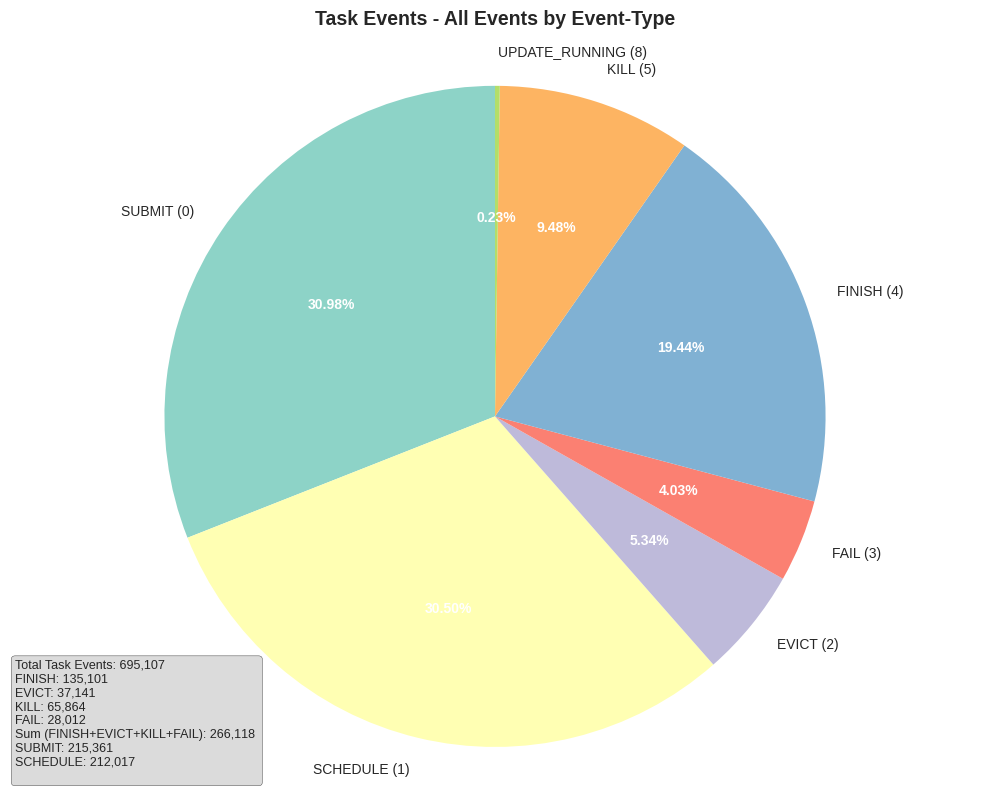

In [30]:
### Chart 1: Task Events - All Event Types

print("\n=== Chart 1: Task Events - All Event Types ===")

# Event type mapping
event_type_names = {
    0: "SUBMIT", 1: "SCHEDULE", 2: "EVICT", 3: "FAIL", 4: "FINISH",
    5: "KILL", 6: "LOST", 7: "UPDATE_PENDING", 8: "UPDATE_RUNNING"
}

# Use already calculated distribution
task_event_rows = task_event_distribution_with_pct.collect()

task_event_types = []
task_event_counts = []
task_event_percent = []
task_event_labels = []

for row in task_event_rows:
    event_type = row['event_type']
    task_event_types.append(event_type)
    task_event_counts.append(row['count'])
    task_event_percent.append(row['percentage'])
    name = event_type_names.get(event_type, f"UNKNOWN_{event_type}")
    task_event_labels.append(f"{name} ({event_type})")

plt.figure(figsize=(10, 8))
colors_task = plt.cm.Set3(range(len(task_event_counts)))

wedges, texts, autotexts = plt.pie(task_event_counts,
                                  labels=task_event_labels,
                                  colors=colors_task,
                                  autopct='%1.2f%%',
                                  startangle=90,
                                  #explode=[0.1 if et in [2, 5] else 0 for et in task_event_types] # highlight evicted and killed
                            )

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

plt.title('Task Events - All Events by Event-Type',
          fontsize=14, fontweight='bold', pad=20)

total_task_events = sum(task_event_counts)

# Get absolute counts from the already calculated data
evicted_count = task_event_counts[task_event_types.index(2)] if 2 in task_event_types else 0
killed_count = task_event_counts[task_event_types.index(5)] if 5 in task_event_types else 0
failed_count = task_event_counts[task_event_types.index(3)] if 3 in task_event_types else 0
finished_count = task_event_counts[task_event_types.index(4)] if 4 in task_event_types else 0
submit_count = task_event_counts[task_event_types.index(0)] if 0 in task_event_types else 0
schedule_count = task_event_counts[task_event_types.index(1)] if 1 in task_event_types else 0



# Sum of important end events
end_events_sum = evicted_count + killed_count + failed_count + finished_count

plt.figtext(0.02, 0.02,
            f"Total Task Events: {total_task_events:,}\n"
            f"FINISH: {finished_count:,} \n"
            f"EVICT: {evicted_count:,} \n"
            f"KILL: {killed_count:,} \n"
            f"FAIL: {failed_count:,} \n"
            f"Sum (FINISH+EVICT+KILL+FAIL): {end_events_sum:,} \n"
            f"SUBMIT: {submit_count:,} \n"
            f"SCHEDULE: {schedule_count:,} \n"
            ,
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))

plt.axis('equal')
plt.tight_layout()
plt.savefig('task_events_all_types.png', dpi=300, bbox_inches='tight')
plt.show()



=== Chart 2: Task Events - End Event Types Only ===


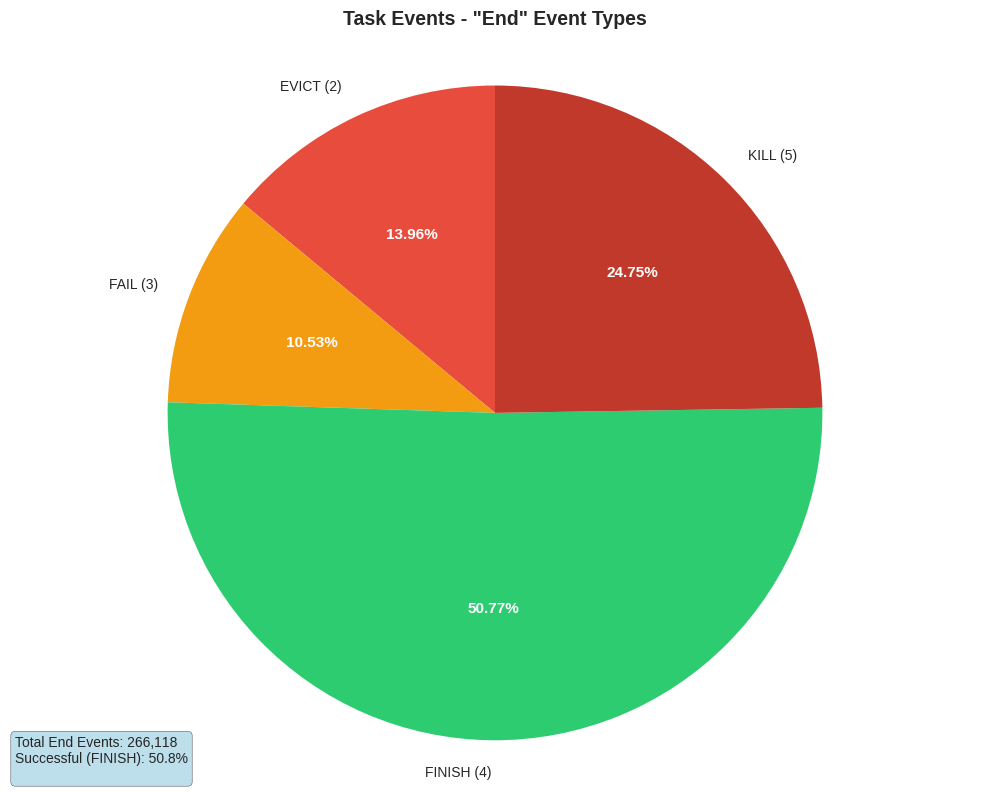

In [43]:
### Chart 2: Task Events - End Event Types Only

print("\n=== Chart 2: Task Events - End Event Types Only ===")

end_event_types = [2, 3, 4, 5, 6]
end_event_names = {2: "EVICT", 3: "FAIL", 4: "FINISH", 5: "KILL", 6: "LOST"}

# Use already calculated distribution
task_event_rows = task_event_distribution_with_pct.filter(task_event_distribution_with_pct.event_type.isin(end_event_types))
#.collect()

task_end_types = []
task_end_counts = []
task_end_labels = []

for row in task_event_rows.collect():
    event_type = row['event_type']
    count = row['count']
    task_end_types.append(event_type)
    task_end_counts.append(count)
    name = end_event_names.get(event_type, f"UNKNOWN_{event_type}")
    task_end_labels.append(f"{name} ({event_type})")

plt.figure(figsize=(10, 8))

# Custom colors for end events
task_colors = []
for event_type in task_end_types:
    if event_type == 4:    # FINISH - green
        task_colors.append('#2ecc71')
    elif event_type == 2:  # EVICT - red
        task_colors.append('#e74c3c')
    elif event_type == 5:  # KILL - dark red
        task_colors.append('#c0392b')
    elif event_type == 3:  # FAIL - orange
        task_colors.append('#f39c12')
    elif event_type == 6:  # LOST - purple
        task_colors.append('#9b59b6')

task_explode = [0.1 if et in [2, 3, 5, 6] else 0 for et in task_end_types]

wedges, texts, autotexts = plt.pie(task_end_counts,
                                  labels=task_end_labels,
                                  colors=task_colors,
                                  autopct='%1.2f%%',
                                  startangle=90,
                                  #explode=task_explode
                                  )

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

plt.title('Task Events - "End" Event Types',
          fontsize=14, fontweight='bold', pad=20)

total_task_end = sum(task_end_counts)
task_success = task_end_counts[task_end_types.index(4)] if 4 in task_end_types else 0
task_success_pct = (task_success / total_task_end * 100) if total_task_end > 0 else 0

plt.figtext(0.02, 0.02,
           f"Total End Events: {total_task_end:,}\n" +
           f"Successful (FINISH): {task_success_pct:.1f}%\n",
           fontsize=10,
           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))

plt.axis('equal')
plt.tight_layout()
plt.savefig('task_events_end_types.png', dpi=300, bbox_inches='tight')
plt.show()



=== Events per Job ID and Task ID Analysis ===

Statistics of events per task:
+-------+------------------+
|summary|       event_count|
+-------+------------------+
|  count|            223921|
|   mean| 7.159435693838452|
| stddev|31.974316111414517|
|    min|                 1|
|    max|              2712|
+-------+------------------+


Distribution of event counts per task:
+-----------+---------+
|event_count|num_tasks|
+-----------+---------+
|          1|    10177|
|          2|    12238|
|          3|   154495|
|          4|     1159|
|          5|      553|
|          6|    18313|
|          7|      454|
|          8|      351|
|          9|     2671|
|         10|      230|
|         11|      410|
|         12|     1234|
|         13|       79|
|         14|      359|
|         15|      592|
|         16|       80|
|         17|      235|
|         18|      272|
|         19|       60|
|         20|      115|
+-----------+---------+
only showing top 20 rows


Top 10 tasks wi

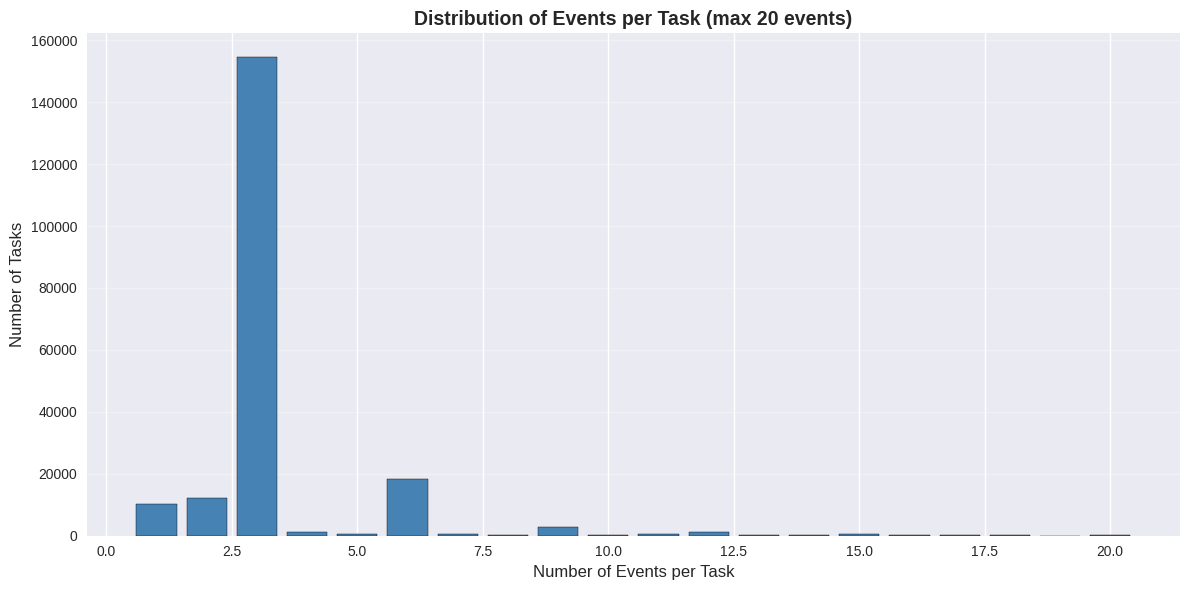

In [45]:
### Analysis: Events per Job ID and Task ID

print("\n=== Events per Job ID and Task ID Analysis ===")

# Count events per job_id and task_id
events_per_task = (
    task_df.groupBy("job_id", "task_id")
    .count()
    .withColumnRenamed("count", "event_count")
)

# Get statistics
event_count_stats = events_per_task.describe("event_count")
print("\nStatistics of events per task:")
event_count_stats.show()

# Distribution of event counts
event_count_distribution = (
    events_per_task.groupBy("event_count")
    .count()
    .orderBy("event_count")
    .withColumnRenamed("count", "num_tasks")
)

print("\nDistribution of event counts per task:")
event_count_distribution.show(20)

# Find tasks with most events
top_tasks = events_per_task.orderBy("event_count", ascending=False).limit(10)
print("\nTop 10 tasks with most events:")
top_tasks.show()

# Visualize distribution
event_dist_data = event_count_distribution.filter(F.col("event_count") <= 20).collect()

if event_dist_data:
    counts = [row['event_count'] for row in event_dist_data]
    num_tasks = [row['num_tasks'] for row in event_dist_data]

    plt.figure(figsize=(12, 6))
    plt.bar(counts, num_tasks, color='steelblue', edgecolor='black')
    plt.xlabel('Number of Events per Task', fontsize=12)
    plt.ylabel('Number of Tasks', fontsize=12)
    plt.title('Distribution of Events per Task (max 20 events)', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('events_per_task_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()


=== Analysis: Tasks with exactly 3 events ===

Most frequent event combinations (sorted):
+-----------+------+
|event_combo|count |
+-----------+------+
|[0, 1, 4]  |121815|
|[0, 1, 5]  |27669 |
|[0, 1, 2]  |4597  |
|[0, 1, 3]  |411   |
|[0, 2, 5]  |1     |
|[0, 1, 8]  |1     |
|[0, 3, 5]  |1     |
+-----------+------+


=== Top 10 Event Combinations with Names ===
1. ['SUBMIT', 'SCHEDULE', 'FINISH'] (codes: [0, 1, 4]) - 121,815 tasks
2. ['SUBMIT', 'SCHEDULE', 'KILL'] (codes: [0, 1, 5]) - 27,669 tasks
3. ['SUBMIT', 'SCHEDULE', 'EVICT'] (codes: [0, 1, 2]) - 4,597 tasks
4. ['SUBMIT', 'SCHEDULE', 'FAIL'] (codes: [0, 1, 3]) - 411 tasks
5. ['SUBMIT', 'EVICT', 'KILL'] (codes: [0, 2, 5]) - 1 tasks
6. ['SUBMIT', 'SCHEDULE', 'UPDATE_RUNNING'] (codes: [0, 1, 8]) - 1 tasks
7. ['SUBMIT', 'FAIL', 'KILL'] (codes: [0, 3, 5]) - 1 tasks


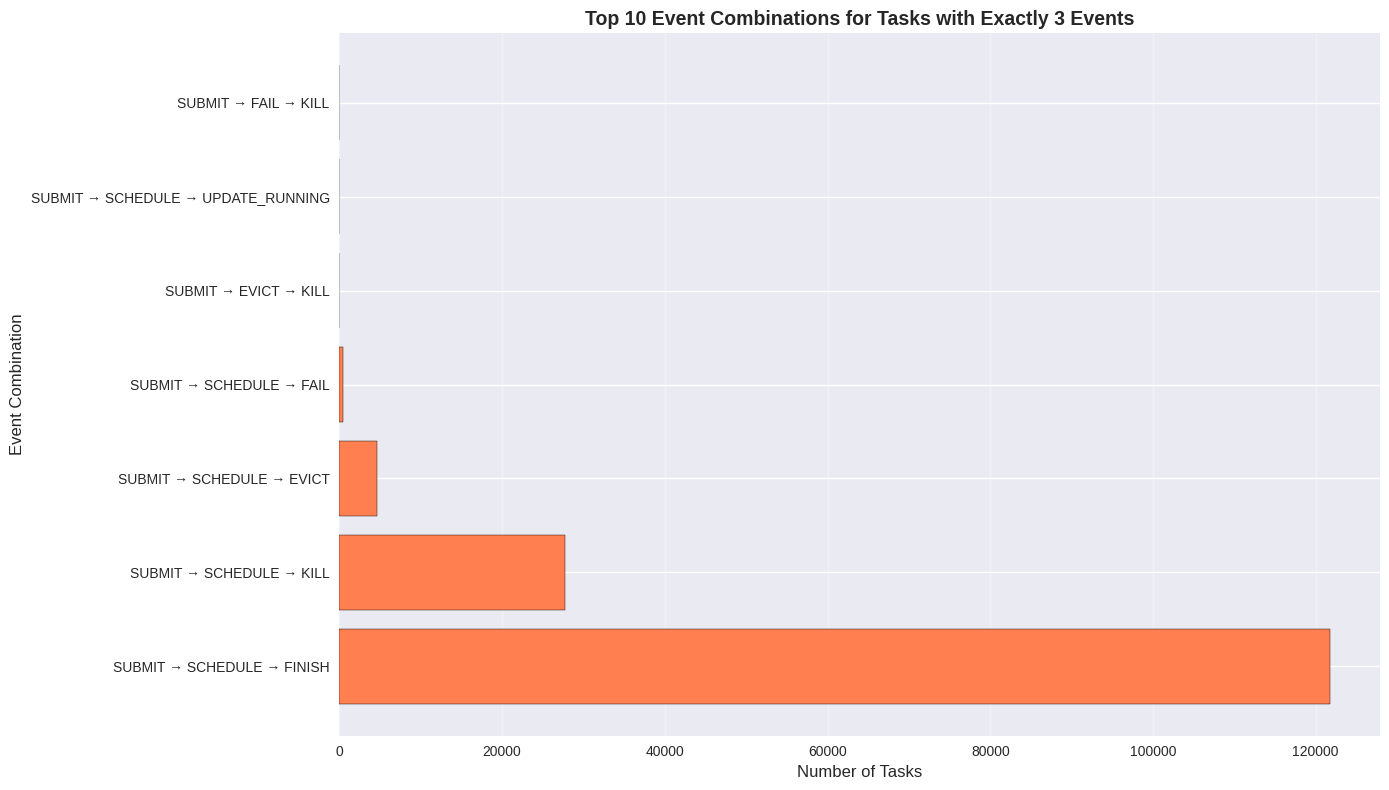

In [46]:
### Analysis: Which 3 events occur together for tasks with exactly 3 events

print("\n=== Analysis: Tasks with exactly 3 events ===")

# Filter tasks with exactly 3 events
tasks_with_3_events = events_per_task.filter(F.col("event_count") == 3)

# Get the event combinations for these tasks
event_combinations = (
    task_df.join(tasks_with_3_events, on=["job_id", "task_id"])
    .groupBy("job_id", "task_id")
    .agg(F.collect_list("event_type").alias("events"))
)

# Sort the event lists to make combinations comparable
event_combinations_sorted = event_combinations.withColumn(
    "event_combo",
    F.array_sort(F.col("events"))
)

# Count frequency of each combination
combo_frequency = (
    event_combinations_sorted.groupBy("event_combo")
    .count()
    .orderBy("count", ascending=False)
)

print("\nMost frequent event combinations (sorted):")
combo_frequency.show(20, truncate=False)

# Translate to readable format
combo_data = combo_frequency.collect()

event_type_names = {
    0: "SUBMIT", 1: "SCHEDULE", 2: "EVICT", 3: "FAIL", 4: "FINISH",
    5: "KILL", 6: "LOST", 7: "UPDATE_PENDING", 8: "UPDATE_RUNNING"
}

print("\n=== Top 10 Event Combinations with Names ===")
for i, row in enumerate(combo_data[:10], 1):
    combo = row['event_combo']
    count = row['count']
    names = [event_type_names.get(et, f"UNKNOWN_{et}") for et in combo]
    print(f"{i}. {names} (codes: {combo}) - {count:,} tasks")

# Visualize top combinations
if len(combo_data) > 0:
    top_n = min(10, len(combo_data))
    combo_labels = []
    combo_counts = []

    for row in combo_data[:top_n]:
        combo = row['event_combo']
        names = [event_type_names.get(et, str(et)) for et in combo]
        combo_labels.append(" → ".join(names))
        combo_counts.append(row['count'])

    plt.figure(figsize=(14, 8))
    plt.barh(range(len(combo_labels)), combo_counts, color='coral', edgecolor='black')
    plt.yticks(range(len(combo_labels)), combo_labels, fontsize=10)
    plt.xlabel('Number of Tasks', fontsize=12)
    plt.ylabel('Event Combination', fontsize=12)
    plt.title('Top 10 Event Combinations for Tasks with Exactly 3 Events',
              fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('event_combinations_3_events.png', dpi=300, bbox_inches='tight')
    plt.show()